In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm,t,skew,kurtosis
from scipy.optimize import minimize

In [4]:
# Import my library
from risklib import fitted_model,portfolio,riskstats,simulate

## Problem1

In [14]:
# Risk metrics functions for simulated series a
# Will Use library later
def VaR(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    return -v

def ES(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    es = a[a<=v].mean()
    return -es

In [15]:
# Simulate from generalized T
# Put in library fited_model later
def fit_general_t(x,nsim=10000):
    def t_fit(vals,r):
        nu = vals[0]
        miu = vals[1]
        s = vals[2]
        ll = t.logpdf(r,df=nu,loc=miu,scale=s).sum()
        return -ll
    # start values bases on moments
    start_m = x.mean()
    start_nu = 6.0/kurtosis(x) + 4
    start_s = math.sqrt(x.var()*start_nu/(start_nu-2))
    ll_t_res = minimize(t_fit,[start_nu,start_m,start_s],args=x,
    constraints=({'type':'ineq','fun': lambda vals: vals[0]-2.001},{'type':'ineq','fun': lambda vals: vals[2]-1e-6}))
    print(ll_t_res.message)
    nu,miu,s = ll_t_res.x[0],ll_t_res.x[1],ll_t_res.x[2]
    ysim = t.rvs(df=nu,loc=miu,scale=s,size=nsim)
    return ysim

In [16]:
# Plot Var and ES
def plot_var_es(r,var,es,method):
    sns.displot(r,kde=True)
    plt.axvline(-var, color="Red",label="VaR")
    plt.axvline(-es, color="Blue",label="ES")
    plt.title(method)
    plt.legend()
    plt.plot()

In [17]:
# Implement normal fitting on problem 1 data
def fit_norm_sim(x,nsim=10000):
    ysim = np.random.normal(x.mean(),x.std(),nsim)
    return ysim

In [18]:
# Read in data from problem1.csv
data1 = pd.read_csv("problem1.csv")
x= data1['x']

Generalized Normal VaR: 0.08060698561159398
Generalized Normal ES: 0.10270048944421077


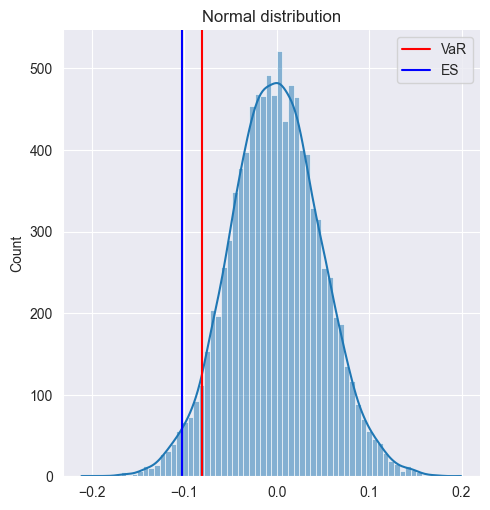

In [33]:
ysim_norm = fit_norm_sim(x)
plot_var_es(ysim_norm,VaR(ysim_norm),ES(ysim_norm),"Normal distribution")
print("Generalized Normal VaR: {}".format(VaR(ysim_norm)))
print("Generalized Normal ES: {}".format(ES(ysim_norm)))

Optimization terminated successfully
Generalized T VaR: 0.07872074956179001
Generalized T ES: 0.11335483962731195


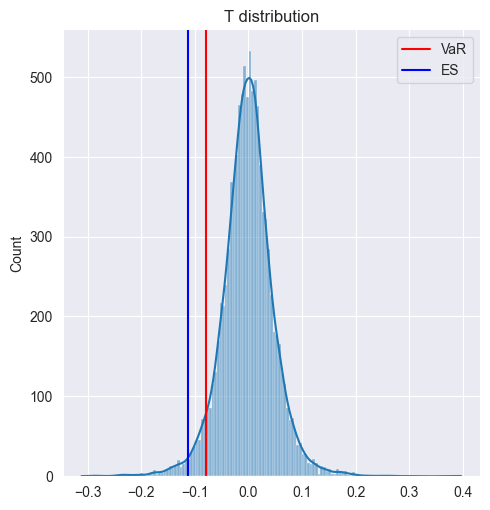

In [34]:
# Implement Generalized T on Y
ysim_t = fit_general_t(x,nsim=10000)
plot_var_es(ysim_t,VaR(ysim_t),ES(ysim_t),"T distribution")
print("Generalized T VaR: {}".format(VaR(ysim_t)))
print("Generalized T ES: {}".format(ES(ysim_t)))

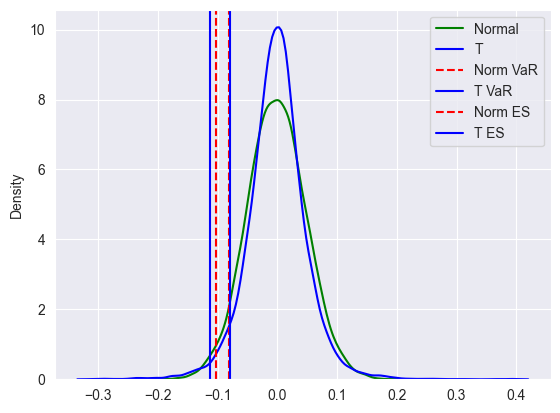

In [35]:
# Put together to compare
sns.kdeplot(ysim_norm,color="Green",label="Normal")
sns.kdeplot(ysim_t,color="Blue",label="T")
plt.axvline(-VaR(ysim_norm), color="Red",label="Norm VaR",linestyle="--")
plt.axvline(-VaR(ysim_t), color="blue",label="T VaR")
plt.axvline(-ES(ysim_norm), color="Red",label="Norm ES",linestyle="--")
plt.axvline(-ES(ysim_t), color="blue",label="T ES")
plt.legend()

## Problem3

In [5]:
price_data = pd.read_csv("DailyPrices.csv")
port_data = pd.read_csv("portfolio.csv")

In [9]:
# Copula calculation
def copula_port(port,pricedata,portdata,nsim,seed):
    r,cur_price,cur_value,port_info = portfolio.port_cal(port,pricedata,portdata)
    # Remove the mean for returns
    r_h = r.sub(r.mean(),axis=1)
    # Fit the generalized T model for all stocks
    # Construct Copula
    r_fitted = {}
    U =pd.DataFrame()
    for stock in r_h.columns:
        r_fitted[stock]= fitted_model.fit_general_t(r_h[stock])
        U[stock]= r_fitted[stock].u
    R = U.corr(method='pearson')
    # Simulate
    Nsim =simulate.pca_sim(R,nsim=nsim,seed=seed,means=r.mean())
    Usim = norm.cdf(Nsim)
    # Change to dataframe
    Usim = pd.DataFrame(Usim,columns = r_h.columns)
    rsim = pd.DataFrame(columns = r_h.columns)
    for stock in r_h.columns:
        rsim[stock] = r_fitted[stock].inv_cdf(Usim[stock])
    p_new = (rsim+1).mul(cur_price)
    # Calulate portfolio value for each draw
    port_value = p_new.mul(port_info['Holding'].values).sum(axis=1)
    profit = port_value- cur_value
    profit = profit.to_numpy(copy=True)
    var = riskstats.VaR(profit,0.05)
    es = riskstats.ES(profit,0.05)
    return var,es,profit

Var for Portfolio A: 8142.450921713115
ES for Portfolio A: 10543.916282464354


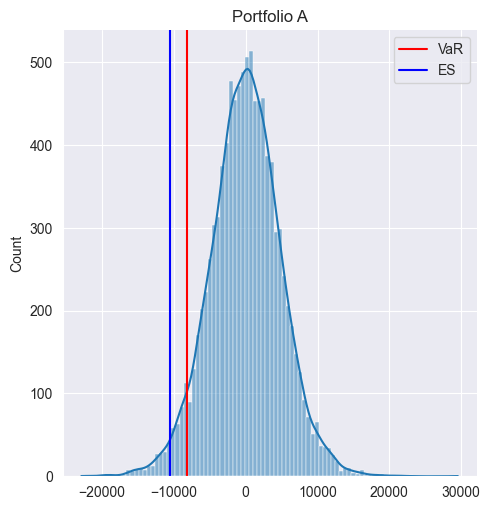

In [10]:
#Portfolio A
copula_a = copula_port("A",price_data,port_data,10000,10)
print("Var for Portfolio A: {}".format(copula_a[0]))
print("ES for Portfolio A: {}".format(copula_a[1]))
plot_var_es(copula_a[2],copula_a[0],copula_a[1],"Portfolio A")

Var for Portfolio B: 6752.625333020408
ES for Portfolio B: 8797.952674100794


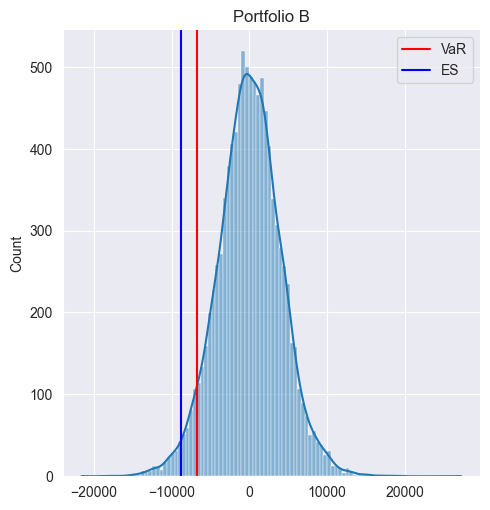

In [11]:
#Portfolio B
copula_b = copula_port("B",price_data,port_data,10000,10)
print("Var for Portfolio B: {}".format(copula_b[0]))
print("ES for Portfolio B: {}".format(copula_b[1]))
plot_var_es(copula_b[2],copula_b[0],copula_b[1],"Portfolio B")

Var for Portfolio C: 5696.508227395269
ES for Portfolio C: 7469.7825422302485


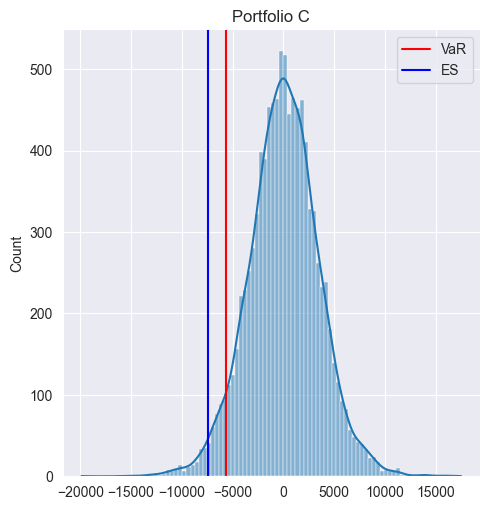

In [12]:
#Portfolio C
copula_c = copula_port("C",price_data,port_data,10000,10)
print("Var for Portfolio C: {}".format(copula_c[0]))
print("ES for Portfolio C: {}".format(copula_c[1]))
plot_var_es(copula_c[2],copula_c[0],copula_c[1],"Portfolio C")

Var for Portfolio All: 20286.751545873445
ES for Portfolio All: 26495.16875781433


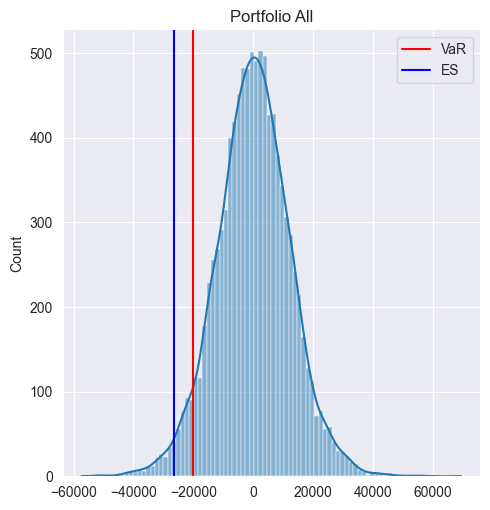

In [13]:
#Portfolio All
copula_all = copula_port("All",price_data,port_data,10000,10)
print("Var for Portfolio All: {}".format(copula_all[0]))
print("ES for Portfolio All: {}".format(copula_all[1]))
plot_var_es(copula_all[2],copula_all[0],copula_all[1],"Portfolio All")